# __The Battle of Hamburg’s Districts for a new Study Café__ 
#### A Capstone Project for the IBM "Applied Data Science Capstone" | by Karima<br>

The aim of this project is to help investors in finding the optimal location for opening a new study café by giving them a nice visual overview of Hamburg's districts and their relevant characteristics. To this end, this notebook collects and combines several data about Hamburg (e.g. rental prices, locations data of universities, venues, and districts) and visualizes these data on a geographical map of Hamburg. Based on this map, we will identify districts that meet the required criteria for the new venue, i.e. close proximity to univerisites, low to moderate rental prices, lively area with other food & drink venues, but not too many other cafés yet. Let's get started!

----
#### __Table of contents:__
__1. Data collection and cleaning__<br>
  1.1. Get names and geographical coordinates of Hamburg's universities<br>
  1.2. Get names and geographical coordinates of Hamburg's districts<br>
  1.3. Get rental prices of Hamburg's districts<br>
  1.4. Combine rental price and location data of Hamburg's districts<br>
  1.5. Get venue data of Hamburg's districts<br>

__2. Data exploration and analysis__<br>
  2.1. Data exploration<br>
  2.2. Clustering Hamburg's districts by venues<br>
  2.3. Visualization of results in a Folium map<br>
  
-----

## __Part 1: Data collection and cleaning__ 

First import all the dependencies that we will need.

In [1]:
import pandas as pd
import numpy as np
import requests # library to handle requests

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed folium yet
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed geopy yet lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans  # import k-means from clustering stage

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt

# use the inline backend to generate the plots within the browser
%matplotlib inline  

print('Libraries imported.')

Libraries imported.


#### __Part 1.1:__ Get names and geographical coordinates of Hamburg's universities

First we get the names of Hamburg's universities from the internet.

In [2]:
HH_unis = pd.read_html('https://www.4icu.org/de/hamburg/')[0]

# Alternative: get data from my html file (in case the website is removed/modified)
# HH_unis = pd.read_html('HH_Unis.html')[0]  

HH_unis = HH_unis.iloc[0:18,1]
HH_unis

0                                   Universität Hamburg
1                        Technische Universität Hamburg
2      Hochschule für Angewandte Wissenschaften Hamburg
3                            Helmut-Schmidt-Universität
4              Hochschule für Musik und Theater Hamburg
5                         HafenCity Universität Hamburg
6                Hochschule für Bildende Künste Hamburg
7                                   Bucerius Law School
8                         Akademie Mode and Design GmbH
9                    Europäische Fernhochschule Hamburg
10                                       EBC Hochschule
11                           Kühne Logistics University
12                        HFH Hamburger Fern-Hochschule
13            Hamburg School of Business Administration
14                               Medical School Hamburg
15    Evangelische Hochschule für Soziale Arbeit und...
16    Brand Academy - Hochschule für Design und Komm...
17    ISS International Business School of Servi

Then we get the geographical coordinates (latitude and longitude) of each university using the geopy client with the Nominatim service. Note that we use NaN values in case no result is returned. 

In [3]:
hh_unis = pd.DataFrame(columns=['University','Lat','Lon'])

for uni in HH_unis:
    
    address = uni + ', Hamburg'
    geolocator = Nominatim(user_agent="hh_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        hh_unis = hh_unis.append({'University': uni, 'Lat': latitude, 'Lon': longitude}, ignore_index=True)
    else:
        hh_unis = hh_unis.append({'University': uni, 'Lat': float('nan'), 'Lon': float('nan')}, ignore_index=True)
    
hh_unis

,University,Lat,Lon
0,Universität Hamburg,53.480616,10.240777
1,Technische Universität Hamburg,53.461007,9.969227
2,Hochschule für Angewandte Wissenschaften Hamburg,53.493382,10.200562
3,Helmut-Schmidt-Universität,53.569364,10.109597
4,Hochschule für Musik und Theater Hamburg,53.570173,9.998745
5,HafenCity Universität Hamburg,53.540215,10.004820
6,Hochschule für Bildende Künste Hamburg,53.567270,10.031578
7,Bucerius Law School,53.559336,9.983477
8,Akademie Mode and Design GmbH,NaN,NaN
9,Europäische Fernhochschule Hamburg,NaN,NaN


As we see in the dataframe above, the geolocator did not return coordinates for 6 of the 18 universities. Therefore, we get and insert the latitude and longitude of these 6 universities manually using Google Maps. Also, when visualizing the universities on a Folium map (see part 2.3 of this notebook), I noticed that the returned coordinates for the "Universität Hamburg" were wrong, hence I also corrected them manually.

In [4]:
# add/correct the remaining coordinates manually
hh_unis.iloc[hh_unis[hh_unis.University=='Universität Hamburg'].index,1] = float(53.566628)
hh_unis.iloc[hh_unis[hh_unis.University=='Universität Hamburg'].index,2] = float(9.984695)

hh_unis.iloc[hh_unis[hh_unis.University=='Akademie Mode and Design GmbH'].index,1] = float(53.567173)
hh_unis.iloc[hh_unis[hh_unis.University=='Akademie Mode and Design GmbH'].index,2] = float(10.000464)

hh_unis.iloc[hh_unis[hh_unis.University=='Europäische Fernhochschule Hamburg'].index,1] = float(53.603583)
hh_unis.iloc[hh_unis[hh_unis.University=='Europäische Fernhochschule Hamburg'].index,2] = float(10.151324)

hh_unis.iloc[hh_unis[hh_unis.University=='EBC Hochschule'].index,1] = float(53.5576331)
hh_unis.iloc[hh_unis[hh_unis.University=='EBC Hochschule'].index,2] = float(9.9919131)

hh_unis.iloc[hh_unis[hh_unis.University=='HFH Hamburger Fern-Hochschule'].index,1] = float(53.582709)
hh_unis.iloc[hh_unis[hh_unis.University=='HFH Hamburger Fern-Hochschule'].index,2] = float(10.050301)

hh_unis.iloc[hh_unis[hh_unis.University=='Brand Academy - Hochschule für Design und Kommunikation'].index,1] = float(53.546106)
hh_unis.iloc[hh_unis[hh_unis.University=='Brand Academy - Hochschule für Design und Kommunikation'].index,2] = float(9.930807)

hh_unis.iloc[hh_unis[hh_unis.University=='ISS International Business School of Service Management'].index,1] = float(53.580928)
hh_unis.iloc[hh_unis[hh_unis.University=='ISS International Business School of Service Management'].index,2] = float(10.008827)

# Optional: Save the dataframe to a csv file as backup
# hh_unis.to_csv('hh_unis.csv',index=False)

hh_unis

,University,Lat,Lon
0,Universität Hamburg,53.566628,9.984695
1,Technische Universität Hamburg,53.461007,9.969227
2,Hochschule für Angewandte Wissenschaften Hamburg,53.493382,10.200562
3,Helmut-Schmidt-Universität,53.569364,10.109597
4,Hochschule für Musik und Theater Hamburg,53.570173,9.998745
5,HafenCity Universität Hamburg,53.540215,10.004820
6,Hochschule für Bildende Künste Hamburg,53.567270,10.031578
7,Bucerius Law School,53.559336,9.983477
8,Akademie Mode and Design GmbH,53.567173,10.000464
9,Europäische Fernhochschule Hamburg,53.603583,10.151324


#### __Part 1.2:__ Get names and geographical coordinates of Hamburg's districts

First, we download a geojson file with the namea and geographical borders (latitudes and longitudes) of Hamburg's districts.

In [5]:
# download Hamburg's geojson file
!wget --quiet https://gist.github.com/webtobesocial/935759ba975ffd9f6df6d1059fe5ad82/raw/191f44e01e8d5f71451170b9d6746eefddb5c8da/hamburg_city_districts.geojson -O hh_districts.geojson
hh_geo = r'hh_districts.geojson' # geojson file

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


Next, we read out the data contained in this geojson file and extract the names of all districts.

In [6]:
with open('hh_districts.geojson') as json_data:
    hh_json = json.load(json_data)
print('Done!')

Done!


In [7]:
# Get distric names from geojson file
hh_data = hh_json['features']
districts_json = []

for data in hh_data:
    district = data['properties']['Stadtteil'] 
    districts_json.append(district)
    
print('The geojson file has', len(districts_json), 'districts.')
districts_json[0:5]

The geojson file has 104 districts.


['Allermöhe', 'Alsterdorf', 'Altengamme', 'Altenwerder', 'Altona-Altstadt']

#### __Part 1.3:__ Get rental prices of Hamburg's districts

First, we  download a list of rental prices (in €/m²) of Hamburg's districts for the year 2019 from the internet.

In [8]:
df1 = pd.read_html('https://www.wohnungsboerse.net/mietspiegel-Hamburg/3195')[3]
df2 = pd.read_html('https://www.wohnungsboerse.net/mietspiegel-Hamburg/3195')[4]

# Alternative: get data from my html file (in case the website is removed/modified)
# df1 = pd.read_html('HH_RentIndex_2019.html')[3]  
# df2 = pd.read_html('HH_RentIndex_2019.html')[4]

hh_Prices = pd.concat([df1,df2])
hh_Prices.reset_index(inplace=True, drop=True)
hh_Prices.rename(columns={'STADTTEIL':'District','€/m²':'Price'}, inplace=True)
hh_Prices.head()

,District,Price
0,Allermöhe pdfData.whgDistrictPrices.push({ di...,"10,80 €"
1,Alsterdorf pdfData.whgDistrictPrices.push({ d...,"13,88 €"
2,Altona-Altstadt pdfData.whgDistrictPrices.push...,"15,36 €"
3,Altona-Nord pdfData.whgDistrictPrices.push({ ...,"16,25 €"
4,Bahrenfeld pdfData.whgDistrictPrices.push({ d...,"13,61 €"


Let's clean the data: We remove the extension 'pdfData.whg...' from each distric name and convert the rental prices to floats.

In [9]:
# Clean district names
hh_Prices.District = hh_Prices.District.map(lambda x: x[0:x.find(' pdfData')])

# Convert prices to float
hh_Prices.Price = hh_Prices.Price.str.replace(u'\xa0€', u'')
hh_Prices.Price = hh_Prices.Price.str.replace(',','.')
hh_Prices.Price = pd.to_numeric(hh_Prices.Price)

hh_Prices.head()

,District,Price
0,Allermöhe,10.80
1,Alsterdorf,13.88
2,Altona-Altstadt,15.36
3,Altona-Nord,16.25
4,Bahrenfeld,13.61


Now let's check the number of districts that are included in the resulting dataframe.

In [10]:
print('The hh_Prices dataframe has', len(hh_Prices.District.values), 'districts.')
hh_Prices.District[0:5].tolist()

The hh_Prices dataframe has 86 districts.


['Allermöhe', 'Alsterdorf', 'Altona-Altstadt', 'Altona-Nord', 'Bahrenfeld']

#### __Part 1.4:__ Combine rental price and location data of Hamburg's districts

While the geojson file includes __104__ districts, this dataframe includes only __86__ districts. Seems that rental prices are not available for all of Hamburg's districts. Since we want to combine both the location and rental price data later, we first check if all distric names in the "hh_Prices" dataframe match the district names obtained from the geojson file (see 1.2) and print the ones that do not match.

In [11]:
for d in hh_Prices.District:
    if (d not in districts_json):
        print(d)

Hamb.-Altstadt
Hamm-Mitte
Hamm-Nord
Hamm-Süd
St. Georg
St. Pauli


Let's change these names to the names in the geojson file and let's also combine the three subdistricts "Hamm-Mitte", "Hamm-Nord", and "Hamm-Süd" to "Hamm", using the average rental price of these three combined subdistricts as the rental price for "Hamm".

In [12]:
# change district names to the ones in the geojson file
hh_Prices.District.replace('Hamb.-Altstadt','Hamburg-Altstadt',inplace=True)
hh_Prices.District.replace('Hamm-Mitte','Hamm',inplace=True)
hh_Prices.District.replace('Hamm-Nord','Hamm',inplace=True)
hh_Prices.District.replace('Hamm-Süd','Hamm',inplace=True)
hh_Prices.District.replace('St. Georg','St.Georg',inplace=True)
hh_Prices.District.replace('St. Pauli','St.Pauli',inplace=True)

# group the three "Hamm" districts and get the average rental price
hh_Prices = hh_Prices.groupby('District').mean()
hh_Prices.reset_index(inplace=True)

hh_Prices.head()

,District,Price
0,Allermöhe,10.80
1,Alsterdorf,13.88
2,Altona-Altstadt,15.36
3,Altona-Nord,16.25
4,Bahrenfeld,13.61


Now, let's combine these rental price data with the location data (see 1.2) of Hamburg's districts and create a new dataframe called "hh". Note that we will insert NaN values for those districts for which no rental price is available.

In [13]:
hh = pd.DataFrame(columns=['District','Lat','Lon','Price'])
print('This may take a few seconds.\nWait...', end="", flush=True)

for district in districts_json:
    
    print('.', end="", flush=True)
        
    address = district + ', Hamburg'
    geolocator = Nominatim(user_agent="hh_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    if district in hh_Prices.District.values:
        price = float(hh_Prices.Price[hh_Prices.District==district].values)
    else:
        price = float('nan')
    hh = hh.append({'District': district, 'Lat': latitude, 'Lon': longitude, 'Price': price}, ignore_index=True)

print('Done!')

# Optional: Save the dataframe to a csv file for backup
hh.to_csv('hh.csv',index=False)

hh.head()

This may take a few seconds.
Wait...........................................................................................................Done!


,District,Lat,Lon,Price
0,Allermöhe,53.483600,10.125000,10.80
1,Alsterdorf,53.610541,10.003889,13.88
2,Altengamme,53.429725,10.272787,NaN
3,Altenwerder,53.504700,9.920560,NaN
4,Altona-Altstadt,53.549660,9.945352,15.36


In [ ]:
# Alternative to preceding cell: Load the hh dataframe from my csv file
# hh = pd.read_csv('hh.csv')
# hh.head()

#### __Part 1.5:__ Get venue data of Hamburg's districts

In this part, we will use the Foursquare API to request data on nearby venues for each of Hamburg's districts, which will be used for the clustering analysis later on (see 2.2). We use the API "explore" endpoint with a limit of 100 and a radius of 500 meters around a district's given latitude and longitude. To use the Foursquare API, I first define my Foursquare credentials and version.

In [14]:
CLIENT_ID = 'AALGIC4UUYADR440BQ1QKMYAV3GG3P4HGEUEILXNCUORHUOR' # my Foursquare ID
CLIENT_SECRET = 'XXXXXX will keep this secret XXXXXX' # my Foursquare Secret
VERSION = '20190302'  # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: AALGIC4UUYADR440BQ1QKMYAV3GG3P4HGEUEILXNCUORHUOR
CLIENT_SECRET:XXXXXX will keep this secret XXXXXX


Then, let's define a function that will output the top venues in each district.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    print('This may take a few seconds.\nWait...', end="", flush=True)
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end="", flush=True)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 'District Lat', 'District Lon', 
                  'Venue', 'Venue Lat', 'Venue Lon', 'Venue Category']
    
    return(nearby_venues)
print('Function ready!')

Function ready!


Now we will run the above function on each district and create a new dataframes called "hh_venues".

In [16]:
hh_venues = getNearbyVenues(names=hh.District, latitudes=hh.Lat, longitudes=hh.Lon)
print('Done!')

# Optional: Save hh_venues to csv
# hh_venues.to_csv('hh_venues.csv',index=False)

This may take a few seconds.
Wait...........................................................................................................Done!


In [17]:
# Alternative to above cell: Get hh_venues from my csv file (to save Foursquare requests, which are limited per user and day)
# hh_venues = pd.read_csv('hh_venues.csv')

Let's check the size and first 5 rows of the resulting dataframe.

In [18]:
print(hh_venues.shape)
hh_venues.head()

(1537, 7)


,District,District Lat,District Lon,Venue,Venue Lat,Venue Lon,Venue Category
0,Alsterdorf,53.610541,10.003889,Eppendorfer Moor,53.613315,10.002277,Nature Preserve
1,Alsterdorf,53.610541,10.003889,REWE,53.607687,10.005800,Supermarket
2,Alsterdorf,53.610541,10.003889,Best Western Premier Alsterkrug Hotel,53.613080,9.999037,Hotel
3,Alsterdorf,53.610541,10.003889,Eiskaffee Eis Perle,53.608354,10.009394,Ice Cream Shop
4,Alsterdorf,53.610541,10.003889,Braband,53.613330,10.002281,Café


Before we continue with the next part, let's briefly summarize this "Data collection and cleaning" section: We obtained the names and coordinates of Hamburgs universities and districts, as well as the rental prices for some of these districts. In addition, we requested venue data for each districts using the Foursquare API, including the venue name, venue coordinates, and venue category.

## __Part 2: Data exploration and analysis__ 

In this section, we will explore the data (__2.1__), cluster Hamburg's districts based on their venue characteristics (__2.2__), and finally visualize the results in a choropleth map using Folium (__2.3__).

#### __Part 2.1:__ Data exploration

Before we use the venue data for clustering, let's explore them a little bit. We first check how many unique venue categories were returned in total and plot the number of returned venues per district in a histogram.

There are 239 uniques venue categories.


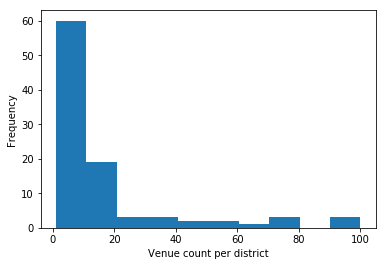

In [19]:
print('There are {} uniques venue categories.'.format(len(hh_venues['Venue Category'].unique())))

# plot a histogram
hh_venues_count = hh_venues.groupby('District').count().iloc[:,0]
hh_venues_count.plot(kind='hist')  

plt.xlabel('Venue count per district')
# Optional: Save the histogram as a png file
# plt.savefig('Venue_Count_Histogram.png')

plt.show()

Let's also look for venue categories that describe Coffee Shops (should start with a 'C' for Café, Coffee etc.).

In [20]:
venue_categories = sorted(hh_venues['Venue Category'].unique().tolist())
venues_C = [category for category in venue_categories if (category.startswith('C'))]
venues_C

['Café',
 'Canal',
 'Candy Store',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Arts Building',
 'Colombian Restaurant',
 'Comedy Club',
 'Comfort Food Restaurant',
 'Comic Shop',
 'Convenience Store',
 'Cosmetics Shop',
 'Cruise',
 'Cultural Center',
 'Cupcake Shop',
 'Currywurst Joint']

Seems that there are two venue categories that label Coffe Shops: __"Café"__ and __"Coffee Shop"__. Let's get the total count of these two venue categories for each district and save it in a new dataframe called 'hh_cafes'. We can use these data later to label each district in the map with the number of coffee shops that are already present in that district (see 2.3).

In [22]:
hh_cafes = pd.DataFrame(columns = ['District','Cafés'])

for district in hh.District:

    district_venues = hh_venues[hh_venues.District == district]
    district_cafes = district_venues[(district_venues['Venue Category']=='Café') | (
        district_venues['Venue Category']=='Coffee Shop')]
    
    hh_cafes = hh_cafes.append({'District':district, 'Cafés':district_cafes.shape[0]}, ignore_index=True)

# Optional: Save hh_cafes to csv
# hh_cafes.to_csv('hh_cafes.csv',index=False)    
    
hh_cafes.head()

,District,Cafés
0,Allermöhe,0
1,Alsterdorf,1
2,Altengamme,0
3,Altenwerder,0
4,Altona-Altstadt,1


Let's also plot the number of returned cafés/coffe shops per district in a histogram.

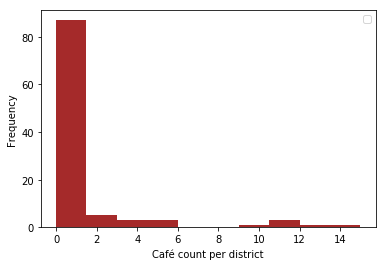

In [23]:
# plot histogram
hh_cafes.plot(kind='hist', color='brown')  

plt.xlabel('Café count per district')
plt.legend('')

# Optional: Save the histogram as a png file
# plt.savefig('Cafe_Count_Histogram.png')

plt.show()

Interesting. Seems that most districts have either no other only very few cafés yet. However, some districts seem to have already many cafés. Let's get the names of these districts with many cafés (>=10) and keep them in mind, since we wouldn't want to open our new study café in such café-rich districts.

In [25]:
hh_cafes.District[hh_cafes.Cafés >= 10].tolist()

['Hamburg-Altstadt', 'Hoheluft-Ost', 'Rotherbaum', 'St.Pauli', 'Sternschanze']

Finally, let's also plot a histogram of the rental prices to get an idea about the rental price distribution.

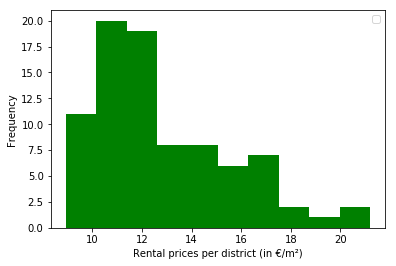

In [26]:
# plot histogram
hh.Price.plot(kind='hist',color='green')  

plt.xlabel('Rental prices per district (in €/m²)')
plt.legend('')

# Optional: Save the histogram as a png file
# plt.savefig('Rental_Price_Histogram.png')

plt.show()

Seems that some districts have very high rental prices! Let's get the names of these districts with extremely high rental prices (>18 €/m²) and keep them in mind, since we wouldn't want to open our new study café in such expensive districts.

In [27]:
hh.District[hh.Price >= 18].tolist()

['HafenCity', 'Hamburg-Altstadt', 'Hammerbrook', 'Harvestehude']

#### __Part 2.2:__ Clustering Hamburg's districts by venues

Now, we will use the venue data (see 1.2) to obtain the mean frequencies of the different venue categories in each district, and then use this feature to group the districts into clusters by the the <i>k</i>-means clustering algorithm.

We first create a dataframe with each district's mean frequencies of the different venue categories.

In [28]:
# one hot encoding
hh_onehot = pd.get_dummies(hh_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hh_onehot['District'] = hh_venues['District'] 

# move district column to the first column
fixed_columns = [hh_onehot.columns[-1]] + list(hh_onehot.columns[:-1])
hh_onehot = hh_onehot[fixed_columns]

# group rows by district and by taking the mean of the frequency of occurrence of each category
hh_grouped = hh_onehot.groupby('District').mean().reset_index()
print(hh_grouped.shape)
hh_grouped.head()

(96, 240)


,District,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Zoo Exhibit
0,Alsterdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,...,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0
1,Altona-Altstadt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Altona-Nord,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.030303,...,0.0,0.0,0.030303,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bahrenfeld,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Barmbek-Nord,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0


Let's also create a dataframe that display the top 10 venue categories in each district. Therefore, we first define a function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
print('Function ready!')

Function ready!


Now we use this function to build a new dataframe with the top 10 venue categories in each district.

In [30]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = hh_grouped['District']

for ind in np.arange(hh_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hh_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsterdorf,Bus Stop,Asian Restaurant,Hotel,Pet Store,Supermarket,Bridge,Bakery,Café,Park,Nature Preserve
1,Altona-Altstadt,Bakery,Italian Restaurant,Drugstore,Burger Joint,Supermarket,Mexican Restaurant,Sports Club,Furniture / Home Store,Market,Park
2,Altona-Nord,Supermarket,Nightclub,German Restaurant,Smoke Shop,Bakery,Hotel,Shipping Store,Sri Lankan Restaurant,Street Food Gathering,Soccer Field
3,Bahrenfeld,Supermarket,Snack Place,Cosmetics Shop,Cocktail Bar,Park,Zoo Exhibit,Fish Market,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,Barmbek-Nord,Bus Stop,Electronics Store,Plaza,Taverna,Sushi Restaurant,Italian Restaurant,Park,Video Store,Playground,Pharmacy


Now let's cluster the districts by their venue frequencies using the <i>k</i>-means clustering algorithm from the sklearn library. As we do not know the optimal <i>k</i> for clustering, we first run the <i>k</i>-means clustering algorithm with different values for <i>k</i> and create an elbow plot that shows the winthin-cluster sum of squares (i.e. inertia or distortion) for each value of <i>k</i>.

In [31]:
# run k-means clustering with different values for k
from sklearn.metrics import silhouette_score

ks = range(1,16)
inertia = []
hh_grouped_clustering = hh_grouped.drop('District', 1)

for k in ks:
    k_means = KMeans(n_clusters=k, random_state=3).fit(hh_grouped_clustering)
    inertia.append(k_means.inertia_)

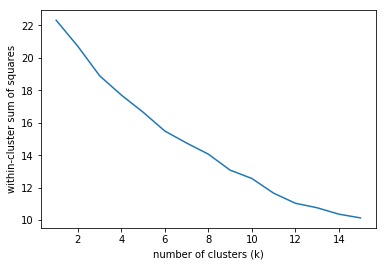

In [32]:
# elbow plot: show the within-cluster sum of squares (inertia or distortion), 
# i.e. the sum of squared distances of samples to their closest cluster center

plt.plot(ks,inertia)
plt.ylabel('within-cluster sum of squares')
plt.xlabel('number of clusters (k)')

# Optional: Save the elbow plot as a png file
# plt.savefig('Elbow_plot.png')

plt.show()

As we see in the plot, there is no clear "elbow" that shows us the optimal value of <i>k</i> for clustering. Note that I also tried alternative methods to determine the optimal <i>k</i>, e.g. the silhouette coefficient or the gap statistic (code not shown to keep the notebook cleaner). However, these methods also yielded no clear answer about the optimal value for <i>k</i>. Hence, the value for clustering was set to <b><i>k</i> = 5</b>, based on the following rationale: On the one hand, we want more than 1-2 clusters to better distinguish the large number of districts based on their different venue characteristics. Yet, we also do not want too many clusters to keep the resulting cluster structure easily understandable (e.g. we do not want many unique clusters that only contain 1-2 districts each).

In [33]:
# run k-means clustering with k=5
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(hh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 4, 1, 4, 4, 1, 2, 4, 4, 4, 4, 4, 3, 1, 1, 1, 2, 4, 4, 1, 4,
       4, 1, 4, 4, 2, 1, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 2, 1, 1, 4,
       4, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 2, 4, 4, 1, 4, 4, 2, 1, 1, 4, 3, 4, 4, 1, 4, 2, 4, 1, 4, 1, 4,
       1, 4, 4, 4, 4, 3, 4, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each district.

In [34]:
# add clustering results to venues data
districts_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
hh_merged = hh.join(districts_venues_sorted.set_index('District'), on='District')
hh_merged.head()

,District,Lat,Lon,Price,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allermöhe,53.483600,10.125000,10.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alsterdorf,53.610541,10.003889,13.88,4.0,Bus Stop,Asian Restaurant,Hotel,Pet Store,Supermarket,Bridge,Bakery,Café,Park,Nature Preserve
2,Altengamme,53.429725,10.272787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Altenwerder,53.504700,9.920560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Altona-Altstadt,53.549660,9.945352,15.36,4.0,Bakery,Italian Restaurant,Drugstore,Burger Joint,Supermarket,Mexican Restaurant,Sports Club,Furniture / Home Store,Market,Park


We see that some districts have NaN as a cluster label, since Foursquare returned no venues within the 500 m radius for these districts. Let's remove these districts with no cluster labels from the dataframe.

In [35]:
print('Before dropping, there are {} districts with NaN entries and {} districts without NaN entries.'.format(
    hh_merged.Cluster.isnull().sum(),hh_merged.Cluster.notnull().sum()))
hh_merged.dropna(subset=['Cluster'], axis=0, inplace=True)
hh_merged.reset_index(inplace=True, drop=True)
print('After dropping, there are {} districts with NaN entries and {} districts without NaN entries.'.format(
    hh_merged.Cluster.isnull().sum(),hh_merged.Cluster.notnull().sum()))

Before dropping, there are 8 districts with NaN entries and 96 districts without NaN entries.
After dropping, there are 0 districts with NaN entries and 96 districts without NaN entries.


Let's look at the first 5 rows of this dataframe.

In [36]:
hh_merged['Cluster'] = hh_merged['Cluster'].astype(int)
hh_merged.head()

,District,Lat,Lon,Price,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsterdorf,53.610541,10.003889,13.88,4,Bus Stop,Asian Restaurant,Hotel,Pet Store,Supermarket,Bridge,Bakery,Café,Park,Nature Preserve
1,Altona-Altstadt,53.549660,9.945352,15.36,4,Bakery,Italian Restaurant,Drugstore,Burger Joint,Supermarket,Mexican Restaurant,Sports Club,Furniture / Home Store,Market,Park
2,Altona-Nord,53.561400,9.944720,16.25,4,Supermarket,Nightclub,German Restaurant,Smoke Shop,Bakery,Hotel,Shipping Store,Sri Lankan Restaurant,Street Food Gathering,Soccer Field
3,Bahrenfeld,53.569070,9.905583,13.61,1,Supermarket,Snack Place,Cosmetics Shop,Cocktail Bar,Park,Zoo Exhibit,Fish Market,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,Barmbek-Nord,53.598894,10.048100,12.47,4,Bus Stop,Electronics Store,Plaza,Taverna,Sushi Restaurant,Italian Restaurant,Park,Video Store,Playground,Pharmacy


Now that we have our different clusters, let's further examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we try to assign a name to each cluster (despite the remaining diversity of venue categories for each cluster).

#### __Cluster 0:__ Memorials

We name this cluster "Memorials", as memorial sites are the first most common venue category in this cluster, which consists of only one district.

In [37]:
hh_cluster0 = hh_merged.loc[hh_merged['Cluster']==0, hh_merged.columns[[0] + list(range(5,10))]]
print('There is {} district in Cluster 0.'.format(hh_cluster0.shape[0]))
hh_cluster0

There is 1 district in Cluster 0.


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
95,Wohldorf-Ohlstedt,Memorial Site,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,French Restaurant


#### __Cluster 1:__ Supermarkets

We name this cluster "Supermarkets" based on the observation that in most districts of this cluster, supermarkets are the first or second most common venue.

In [38]:
hh_cluster1 = hh_merged.loc[hh_merged['Cluster']==1, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} districts in Cluster 1.'.format(hh_cluster1.shape[0]))
hh_cluster1

There are 24 districts in Cluster 1.


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Bahrenfeld,Supermarket,Snack Place,Cosmetics Shop,Cocktail Bar,Park
6,Bergstedt,Supermarket,Department Store,Bus Stop,Bakery,Dim Sum Restaurant
14,Curslack,Supermarket,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,French Restaurant
15,Dulsberg,Supermarket,Bakery,Bus Stop,Park,Metro Station
16,Duvenstedt,Supermarket,Pizza Place,Park,Burger Joint,Café
20,Eißendorf,Supermarket,Bus Stop,Lawyer,Zoo Exhibit,Falafel Restaurant
23,Finkenwerder,Supermarket,Seafood Restaurant,Bakery,Ice Cream Shop,Zoo Exhibit
27,Groß Flottbek,Supermarket,Hotel,Bakery,Café,Pharmacy
30,Hamm,Supermarket,Greek Restaurant,Arts & Crafts Store,Chinese Restaurant,Market
34,Hausbruch,Light Rail Station,Supermarket,Home Service,Asian Restaurant,Food Court


#### __Cluster 2:__ Outdoor & Recreation

We name this cluster "Outdoor & Recreation", since these seem to be the defining characteristics of the districts in this cluster, which include venue types like "Outdoors & Recreation", "Athletics & Sports", "Zoo Exhibit", and "Farm". Note that we do not name this cluster "Bus Stop", since this would not be a very informative name. Still, the fact that bus stops are often the first or second most common venue in these districts might also reflect the fact that these districts have relative low venue density and are located in Hamburg's periphery rather than in Hamburg's center.

In [39]:
hh_cluster2 = hh_merged.loc[hh_merged['Cluster']==2, hh_merged.columns[[0] + list(range(5,10))]]
print('There is {} district in Cluster 2.'.format(hh_cluster2.shape[0]))
hh_cluster2

There is 7 district in Cluster 2.


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Billbrook,Hotel,Bus Stop,Transportation Service,Zoo Exhibit,Falafel Restaurant
17,Eidelstedt,Outdoors & Recreation,Bus Stop,Hostel,Zoo Exhibit,French Restaurant
26,Groß Borstel,Bus Stop,Athletics & Sports,Greek Restaurant,Zoo Exhibit,Farm
40,Hummelsbüttel,Bus Stop,Italian Restaurant,Pharmacy,Liquor Store,Zoo Exhibit
67,Poppenbüttel,Bus Stop,Zoo Exhibit,Dance Studio,Fried Chicken Joint,French Restaurant
71,Rönneburg,Bus Stop,Greek Restaurant,Zoo Exhibit,Fruit & Vegetable Store,French Restaurant
82,Stellingen,Bus Stop,Zoo Exhibit,Gym / Fitness Center,Intersection,Electronics Store


#### __Cluster 3:__ German Restaurants & Zoo

We name this cluster "German Restaurants & Zoo", since these venue types seem to be the defining characteristics of this cluster (although venue types are relatively mixed in this cluster).

In [40]:
hh_cluster3 = hh_merged.loc[hh_merged['Cluster']==3, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} districts in Cluster 3.'.format(hh_cluster3.shape[0]))
hh_cluster3

There are 4 districts in Cluster 3.


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Cranz,German Restaurant,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,French Restaurant
55,Neuenfelde,Sports Club,German Restaurant,Taverna,Falafel Restaurant,French Restaurant
77,Spadenland,German Restaurant,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,French Restaurant
93,Wilstorf,Water Park,German Restaurant,Lake,Zoo Exhibit,Falafel Restaurant


#### __Cluster 4:__ Food & Drink

We name this cluster "Food & Drink". This is by far the largest cluster in the dataset and contains many venue categories that can be subsumed under the term "Food & Drink", e.g. Bars, Cafés, Bakeries, Restaurants, Snack Places etc. This cluster seems to contain exactly the districts that we are interested in for opening a new "study café": Lively places for students to meet and socialize.

In [41]:
hh_cluster4 = hh_merged.loc[hh_merged['Cluster']==4, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} districts in Cluster 4.'.format(hh_cluster4.shape[0]))
hh_cluster4

There are 60 districts in Cluster 4.


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alsterdorf,Bus Stop,Asian Restaurant,Hotel,Pet Store,Supermarket
1,Altona-Altstadt,Bakery,Italian Restaurant,Drugstore,Burger Joint,Supermarket
2,Altona-Nord,Supermarket,Nightclub,German Restaurant,Smoke Shop,Bakery
4,Barmbek-Nord,Bus Stop,Electronics Store,Plaza,Taverna,Sushi Restaurant
5,Barmbek-Süd,Supermarket,Bar,BBQ Joint,Bus Stop,German Restaurant
8,Billstedt,Soccer Field,Bus Stop,German Restaurant,Pub,Flower Shop
9,Billwerder,Light Rail Station,Soccer Field,Food & Drink Shop,Fruit & Vegetable Store,French Restaurant
10,Blankenese,Restaurant,Beach,Hotel,Snack Place,Seafood Restaurant
11,Borgfelde,Asian Restaurant,Hotel,Park,Food,Farmers Market
12,Bramfeld,Bakery,Supermarket,Bar,Grocery Store,Bank


Let's now insert the cluster labels into a new column in the dataframe.

In [42]:
hh_merged['ClusterName'] = hh_merged.Cluster
hh_merged.ClusterName.replace(0,'Memorials',inplace=True)
hh_merged.ClusterName.replace(1,'Supermarkets',inplace=True)
hh_merged.ClusterName.replace(2,'Outdoor & Recreation',inplace=True)
hh_merged.ClusterName.replace(3,'German Restaurants & Zoo',inplace=True)
hh_merged.ClusterName.replace(4,'Food & Drink',inplace=True)

# move district column to the first column
fixed_columns = list(hh_merged.columns[0:5]) + ['ClusterName'] + list(hh_merged.columns[5:15])
hh_merged = hh_merged[fixed_columns]
hh_merged.head()

,District,Lat,Lon,Price,Cluster,ClusterName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsterdorf,53.610541,10.003889,13.88,4,Food & Drink,Bus Stop,Asian Restaurant,Hotel,Pet Store,Supermarket,Bridge,Bakery,Café,Park,Nature Preserve
1,Altona-Altstadt,53.549660,9.945352,15.36,4,Food & Drink,Bakery,Italian Restaurant,Drugstore,Burger Joint,Supermarket,Mexican Restaurant,Sports Club,Furniture / Home Store,Market,Park
2,Altona-Nord,53.561400,9.944720,16.25,4,Food & Drink,Supermarket,Nightclub,German Restaurant,Smoke Shop,Bakery,Hotel,Shipping Store,Sri Lankan Restaurant,Street Food Gathering,Soccer Field
3,Bahrenfeld,53.569070,9.905583,13.61,1,Supermarkets,Supermarket,Snack Place,Cosmetics Shop,Cocktail Bar,Park,Zoo Exhibit,Fish Market,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,Barmbek-Nord,53.598894,10.048100,12.47,4,Food & Drink,Bus Stop,Electronics Store,Plaza,Taverna,Sushi Restaurant,Italian Restaurant,Park,Video Store,Playground,Pharmacy


In [43]:
# Optional: Save dataframe as a csv file for backup
# hh_merged.to_csv('hh_merged.csv', index=False)

#### __Part 2.3:__ Visualization of results in a choropleth map

Now let's visualize the results using <i>Folium</i>. For this, we will label each district with its cluster label, its number of cafés, and its exact rental price (if available) and superimpose these information on the choropleth map using the rental prices of the districts.

In [45]:
# create map
hh_lat = 53.57532
hh_lon = 10.01534
hh_zoom = 10

hh_map = folium.Map(location=[hh_lat, hh_lon], zoom_start=hh_zoom)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
mycolors = ['#834b11', '#00b5eb', '#8000ff', '#363136', '#ff0000']

# color districts by rental price
hh_map.choropleth(
    geo_data=hh_geo,
    data=hh,
    columns=['District', 'Price'],
    key_on='feature.properties.Stadtteil',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rental prices in Hamburg')

# add markers for each university to map
for lat, lon, uni in zip(hh_unis['Lat'], hh_unis['Lon'], hh_unis['University']):
    label = uni
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(hh_map)

# add markers to the map containing for each district the cluster label, rental price, and number of cafés
for lat, lon, district, price, cluster, clabel in zip(hh_merged['Lat'], hh_merged['Lon'], hh_merged['District'], hh_merged['Price'], hh_merged['Cluster'], hh_merged['ClusterName']):
    ncafes = int(hh_cafes.Cafés[hh_cafes.District==district])
    label = folium.Popup(str(district) + ', ' + str(ncafes) + ' Cafés, ' + str(price) + ' €/m² (Cluster ' + str(cluster) + ': ' + clabel + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=mycolors[cluster],
        fill=True,
        fill_color=mycolors[cluster],
        fill_opacity=0.7).add_to(hh_map)

# display map
hh_map

This is it! Above, we have a nice visualization of Hamburg's districts along with their venue characteristics, number of cafés, rental prices, and the locations of universities. This map should aid investors in finding the optimal place to open a new study café. From a look on the map, it seems that the 4 districts <b>Barmbek-Süd</b>, <b>Eilbek</b>, <b>Eimsbüttel</b>, and <b>Ottensen</b> might be good locations to open the new study café for several reasons:
- They are lively districts witch many other Food & Drink venues around, but not too many cafés (<4). 
- They have one or more universities nearby.
- They have moderate rental prices (<15 €/m²).

Let's finally summarize the basic characteristics of these four selected districts in order to present this list to potential investors.

In [47]:
# Summarize selected districts
hh_summary = pd.merge(hh_merged.iloc[:,0:6], hh_cafes, on=['District'])
selected_districts = ['Barmbek-Süd','Eilbek','Eimsbüttel','Ottensen']
hh_selected = hh_summary[hh_summary.District.isin(selected_districts)]
hh_selected.reset_index(inplace=True,drop=True)
hh_selected

,District,Lat,Lon,Price,Cluster,ClusterName,Cafés
0,Barmbek-Süd,53.579885,10.043251,14.50,4,Food & Drink,0
1,Eilbek,53.567237,10.045241,13.75,4,Food & Drink,3
2,Eimsbüttel,53.572483,9.950100,14.12,4,Food & Drink,3
3,Ottensen,53.555066,9.919819,14.42,4,Food & Drink,2


Based on this list and my own experiences from living in Hamburg for more than 15 years, I would specifically recommend the district __Eimsbüttel__, as it is a very lively and nice area, has good traffic connections and good proximity to Hamburg’s center and several universities. 

-----
Thanks for completing this notebook, I hope you enjoyed it!   _Karima_